# Deep Learning for RF Signal Classification Challenge (Demo) 
   by Nick Hale

# Introduction

This demonstration shows part of the ML solution I used in an RF signal classification challenge for the Army Rapid Capabilities Office.  For demonstration purposes, the original problem is reduced from a 24-class to 3-class classification task.  The sample classes (modulation types) are GMSK, QPSK, and BPSK with 500 samples from each class.

This notebook will showcase the main strategy used in the competition which is to train 3 neural networks based on three different representations of the same signals.  The class probabilities predicted by each of the neural networks are then bagged together using the geometric mean.  

In the actual competition, a meta-ensemble pipeline was added with multiple decision tree models trained on the probabilities produced from the neural network ensemble.  This meta-ensemble pipeline further increased the score.  

Further experiments performed using wavelet decompositions and stacked denoising autoencoders.  These methods showed promise, but ran into computational resource contraints of the setup used in the competition.  


# Scoring
![title](images/scoring.png)

# Theory

The main theory used in the challenge is that networks trained on different representations of the data may not be winners on their own, but balancing their predictions has a powerful effect of reducing prediction error, because each of the models individually may be strong/weak at predicting certain types of signals. 

The three representations used are as In-phase / Quadrature (I/Q), Fast Fourier Transform (FFT), and Amplitude / Phase (A/P).  The original data is in I/Q format and is converted into FFT and A/P using the transformations described below.   

![title](images/iq.png)
![title](images/fft.png)
![title](images/AP.png)

# Import and format the signal data

In [2]:
import os
import numpy as np


from keras.utils import normalize as norm

#function to normalize the data
def kerasNorm(X):
    
    return norm(X)



path = os.getcwd()


X = []
y = []

#signal data for each modulation class
sigpaths  = ['/sig1.npy', '/sig2.npy', '/sig3.npy']

for i in range(len(sigpaths)):
    
    datapath = path+sigpaths[i]
    data = np.load(datapath)
    X.append(data)
    
    #constructing y labels
    y.append([i for j in range(len(data))])
    
dim = data.shape

#I/Q Data    
X_iq = np.array(X).reshape((len(sigpaths)*dim[0], dim[1], dim[2]))
#normalize the signal data
X_iq = kerasNorm(X_iq)
y = np.array(y).reshape((len(sigpaths)*dim[0]))
    
print(X_iq.shape, y.shape)

(1500, 2, 1024) (1500,)


# Transform the data into FFT and Amplitude/Phase representations


In [3]:
#FFT
from scipy import fftpack

#convert to complex vectors
complex_X = X_iq[:, 0]+1j*X_iq[:, 1]   

#Take the FFT of the complex vectors

FFT_temp = fftpack.fftshift(complex_X)
fft_dim = X_iq.shape

FFT_X = np.empty(fft_dim)

#Separate the FFT result into real and imaginary vectors
FFT_X[:,0,:] = FFT_temp.real
FFT_X[:,1,:] = FFT_temp.imag
  
print(FFT_X.shape)

(1500, 2, 1024)


In [4]:
#Amplitude / Phase
ap_dim = X_iq.shape
X_ap = np.empty(ap_dim)

X_ap[:][0][1] = np.arctan2(X_iq[:][0][1], X_iq[:][0][0])
X_ap[:][0][0] = np.linalg.norm(X_iq[i,][0], axis=0) 

print(X_ap.shape)

(1500, 2, 1024)


In [5]:
#Create Train/Test Splits for each representations

from sklearn.model_selection import train_test_split

dataidxs = list(range(len(X_iq)))
trainidx, testidx, trainidxy, testidxy = train_test_split(dataidxs, dataidxs, test_size=0.15, random_state=23)

#IQ Train/Test
X_iq_train = X_iq[trainidx]
X_iq_test = X_iq[testidx]

#FFT Train/Test
X_fft_train = FFT_X[trainidx]
X_fft_test = FFT_X[testidx]


#A/P Train/Test
X_ap_train = X_ap[trainidx]
X_ap_test = X_ap[testidx]


#Labels
y_train = y[trainidxy]
y_test = y[testidxy]



#Functions to shape the data for Keras

import keras.utils as ku

def shapeKeras(X):
    
    return X.reshape((-1, 2, 1024, 1))

def shapeKerasY(y, nclasses):
    keras_y = ku.to_categorical(y, num_classes=nclasses)
    
    return keras_y



# Model architectures

Note: the original models were trained on 4 million signal samples

Main features of architecture:
    1.  Deep convolutional layers, deeper than most of RF signal deep learning literature but similar in structure
    2.  batch normalization - faster, more stable training by re-centering/re-scaling input layer
    3.  Dropout - 50% of neurons randomly ignored during training (simple but effective way to prevent overfitting)


In [17]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.optimizers import Adam

def cnnModel():
    
    CNNMODEL = Sequential()
    
    #Convolution input layer 256 neurons, (1,3) filter 
    CNNMODEL.add(Conv2D(256, (1,3), data_format='channels_last', activation='relu', input_shape=((2,1024,1))))
    CNNMODEL.add(BatchNormalization())
    
    #Convolution layer 256 neurons, (1,3) filter, dropout .5
    CNNMODEL.add(Conv2D(256, (1,3), data_format='channels_last', activation='relu'))
    CNNMODEL.add(BatchNormalization())
    CNNMODEL.add(Dropout(0.5))
    
    #Convolution layer 256 neurons, (2,3) filter, dropout .5
    CNNMODEL.add(Conv2D(256, (2,3), data_format='channels_last', activation='relu'))
    CNNMODEL.add(BatchNormalization())
    CNNMODEL.add(Dropout(0.5))
    
    #Convolution layer 128 neurons, (1,3) filter, dropout .5
    CNNMODEL.add(Conv2D(128, (1,3), data_format='channels_last', activation='relu'))
    CNNMODEL.add(BatchNormalization())
    CNNMODEL.add(Dropout(0.5))
    
    #Convolution layer 128 neurons, (1,3) filter, dropout .5
    CNNMODEL.add(Conv2D(128, (1,3), data_format='channels_last', activation='relu'))
    CNNMODEL.add(BatchNormalization())
    CNNMODEL.add(Dropout(0.5))
    
    #Convolution layer 128 neurons, (1,3) filter, dropout .5
    CNNMODEL.add(Conv2D(128, (1,3), data_format='channels_last', activation='relu'))
    CNNMODEL.add(BatchNormalization())
    CNNMODEL.add(Dropout(0.5))
    
    #Convolution layer 64 neurons, (1,3) filter, dropout .5
    CNNMODEL.add(Conv2D(64, (1,3), data_format='channels_last', activation='relu'))
    CNNMODEL.add(BatchNormalization())
    CNNMODEL.add(Dropout(0.5))
    
    #Convolution layer 64 neurons, (1,3) filter, dropout .5
    CNNMODEL.add(Conv2D(64, (1,3), data_format='channels_last', activation='relu'))
    CNNMODEL.add(BatchNormalization())
    CNNMODEL.add(Dropout(0.5))
    
    #Convolution layer 64 neurons, (1,3) filter, dropout .5
    CNNMODEL.add(Conv2D(64, (1,3), data_format='channels_last', activation='relu'))
    CNNMODEL.add(BatchNormalization())
    CNNMODEL.add(Dropout(0.5))
    
    #Dense layer, dropout .5
    CNNMODEL.add(Flatten())
    CNNMODEL.add(Dense(500, use_bias=False))
    CNNMODEL.add(BatchNormalization())
    CNNMODEL.add(Activation('relu'))
    CNNMODEL.add(Dropout(0.5))
    
    #final softmax layer
    CNNMODEL.add(Dense(3, activation='softmax'))
    
    
    #adam optimizer 
    adm = Adam(lr=0.001)
    
    
    CNNMODEL.compile(loss='categorical_crossentropy', optimizer=adm,  metrics = ['accuracy'])
    
    return CNNMODEL

#Create the models

CNN_IQ = cnnModel()
CNN_FFT = cnnModel()
CNN_AP = cnnModel()

# Training the models

In [18]:
#DO NOT RUN IF PRETRAINED, skip to load models

from keras.callbacks import EarlyStopping
Stopping = EarlyStopping(monitor='loss', patience=5, mode='min', verbose=0)
callbacks = [Stopping]

iq_history = CNN_IQ.fit(shapeKeras(X_iq_train), shapeKerasY(y_train, 3), epochs=25, 
                        verbose=0, callbacks=callbacks)
print("CNN_IQ Finished")
fft_history = CNN_FFT.fit(shapeKeras(X_fft_train), shapeKerasY(y_train, 3), epochs=25, 
                          verbose=0, callbacks=callbacks)
print("CNN_FFT Finished")
ap_history = CNN_AP.fit(shapeKeras(X_ap_train), shapeKerasY(y_train, 3), epochs=25, 
                        verbose=0, callbacks=callbacks)
print("CNN_AP Finished")

#save models
CNN_IQ.save(path+'/cnn_iq.h5', save_format='h5', include_optimizer=False)
CNN_FFT.save(path+'/cnn_fft.h5', save_format='h5', include_optimizer=False)
CNN_AP.save(path+'/cnn_ap.h5', save_format='h5', include_optimizer=False)

CNN_IQ Finished
CNN_FFT Finished
CNN_AP Finished


In [19]:
#Process and save histories
import pickle

hist_dict = {'CNN_IQ': iq_history.history, 'CNN_FFT': fft_history.history, 'CNN_AP': ap_history.history }

with open(path+'/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(hist_dict, file_pi)


In [23]:
#load previously saved histories
import pickle
hist_dict = pickle.load(open(path+'/trainHistoryDict', "rb"))

In [7]:
#load pretrained models
from keras.models import load_model
adm = Adam(lr=0.001)

CNN_IQ = load_model(path+'/cnn_iq.h5')
CNN_IQ.compile(loss='categorical_crossentropy', optimizer=adm,  metrics = ['accuracy'])

CNN_FFT = load_model(path+'/cnn_fft.h5')
CNN_FFT.compile(loss='categorical_crossentropy', optimizer=adm,  metrics = ['accuracy'])

CNN_AP = load_model(path+'/cnn_ap.h5')
CNN_AP.compile(loss='categorical_crossentropy', optimizer=adm,  metrics = ['accuracy'])

In [35]:
from sklearn import metrics
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt


def plotTraining(histories):
    
    plt.plot(histories['CNN_IQ']['loss'])
    plt.plot(histories['CNN_FFT']['loss'])
    plt.plot(histories['CNN_AP']['loss'])
    
    plt.title('model training loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['CNN_IQ', "CNN_FFT", "CNN_AP"], loc='upper right')
    plt.show()


def score(y_true, y_pred): 
    
    y_true = shapeKerasY(y_true, 3)
    loss = metrics.log_loss(y_true, y_pred)
    return [100/(1+loss), loss]

def BagPreds(preds, metric='geo'):
    
    if metric == 'geo':
        return gmean(preds)
    
    if metric == 'arith':
        return np.mean(preds)    
    

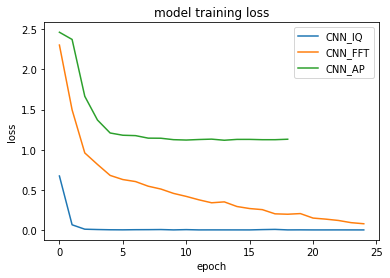

In [29]:
#plot model training

plotTraining(hist_dict)

In [36]:
#Perform inference, ensemble, and score
import pandas as pd
y_pred_iq = CNN_IQ.predict(shapeKeras(X_iq_test))
y_pred_fft = CNN_FFT.predict(shapeKeras(X_fft_test))
y_pred_ap = CNN_AP.predict(shapeKeras(X_ap_test))
#y_pred_iq,
preds = [y_pred_fft, y_pred_ap]

scoredf = pd.DataFrame({'CNN_IQ': score(y_test, y_pred_iq),
                        'CNN_FFT': score(y_test, y_pred_fft),
                        'CNN_AP': score(y_test, y_pred_ap),
                        'CNN_Ensemble': score(y_test, BagPreds(preds))
                       }, index=['Test Score', 'Test logloss'])
scoredf
                        

,CNN_IQ,CNN_FFT,CNN_AP,CNN_Ensemble
Test Score,6.910229,38.975042,47.337311,49.349146
Test logloss,13.471301,1.565745,1.112499,1.026378


# Discussion

The models I/Q model trained on this limited dataset displayed a high degree of overfitting as shown by its extremely low training loss and very high test loss.  The FFT and A/P model did not overfit as much and produced better out of sample scores.  If the IQ model is removed from the ensemble, the bagged predictions of the FFT and A/P models do better than the individual models.